In [1]:
import os.path as op
import os
# import sys
import numpy as np
import pandas as pd
import seaborn as sns
from fpdf import FPDF  

import mne
from mne.preprocessing import find_bad_channels_maxwell
import matplotlib.pyplot as plt
# from mne.time_frequency import psd_multitaper
from mne.preprocessing import annotate_muscle_zscore
from mne.preprocessing import ICA
from mne.preprocessing import read_ica
import scipy.stats

## Preprocessing

In [2]:
data_path =  'D:\projects\WM_GRID\DATA\mg99a'
cal_path = 'D:\projects\WM_GRID\DATA\ctc'
sss_path = 'D:\projects\WM_GRID\DATA\sss'

subject_list = ['mg99']

In [4]:
# %load config.py
"""
===========
Config file
===========

Configurate the parameters of the study.
"""
for subject_id in subject_list[:1]:

    # =============================================================================
    # SESSION-SPECIFIC SETTINGS
    # =============================================================================

    # Set filename based on experiment number

    file_exts = ['%sa01',
                     '%sa02',
                     '%sa03',
                     '%sa04',
                     '%sa05',
                     '%sa06',
                     '%sb07',
                     '%sb08',
                     '%sb09',
                     '%sb10',
                     '%sb11',
                     '%sb12']#,

    file_names = [f % (subject_id) for f in file_exts]


    # =============================================================================
    # GENERAL SETTINGS
    # =============================================================================

    # Set out_path folder or create it if it doesn't exist
    out_path = op.join(data_path, "out_path")
    if not op.exists(out_path):
        os.mkdir(out_path)

    # =============================================================================
    # MAXWELL FILTERING SETTINGS
    # =============================================================================

    # Set filtering method
    method='sss'
    if method == 'tsss':
        st_duration = 10
    else:
        st_duration = None


    # =============================================================================
    # FILTERING AND DOWNSAMPLING SETTINGS
    # =============================================================================

    # Filter and resampling params
    l_freq = 1
    h_freq = 40
    sfreq = 200


    # =============================================================================
    # ICA SETTINGS
    # =============================================================================

    ica_method = 'fastica'
    n_components = 0.99
    max_iter = 800
    random_state = 1688


In [6]:
# %load 01-maxwell_filtering.py
"""
===================================
01. Maxwell filter using MNE-python
===================================

The data are Maxwell filtered using tSSS/SSS.

It is critical to mark bad channels before Maxwell filtering.

Open issues:
    1. SSS or tSSS? -> Consult Alex G.?
    
"""  # noqa: E501


def run_maxwell_filter(method = 'sss'):
    # stdout_obj = sys.stdout                 # store original stdout 
    # sys.stdout = open(op.join(out_path,     # open log file
    # os.path.basename(__file__) + "_%s.txt" % (site_id+subject_id)),'w')
    
    # Load the fine calibration file (which encodes site-specific information 
    # about sensor orientation and calibration) as well as a crosstalk 
    # compensation file (which reduces interference between Elekta’s co-located
    # magnetometer and paired gradiometer sensor units)
    crosstalk_file = op.join(cal_path, "ct_sparse.fif")
    fine_cal_file = op.join(sss_path, "sss_cal.dat")

    # Create empty dataframe for bad channel list
    df = pd.DataFrame()
    
    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")
    
    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        raw_fname_in = op.join(data_path, file_name + '.fif')
        raw = mne.io.read_raw_fif(
            raw_fname_in,
            allow_maxshield=True,
            preload=False,
            verbose=True)
        
        # Detect bad channels
        raw.info['bads'] = []
        raw_check = raw.copy()
        auto_noisy_chs, auto_flat_chs, auto_scores = find_bad_channels_maxwell(
            raw_check, 
            cross_talk=crosstalk_file, 
            calibration=fine_cal_file,
            return_scores=True,
            verbose=True)
        raw.info['bads'].extend(auto_noisy_chs + auto_flat_chs)
        
        # Append bad channels to the list 
        df = df.append({'run': run,
                        'noisy': auto_noisy_chs, 
                        'flat': auto_flat_chs},
                        ignore_index=True)        
        
        # Visualize the scoring used to classify channels as noisy or flat
        ch_type = 'grad'
        fig = viz_badch_scores(auto_scores, ch_type)
        fname_fig = op.join(out_path,
                            "01_r%s_badchannels_%sscore.png" % (run,ch_type))
        fig.savefig(fname_fig)
        plt.close()
        ch_type = 'mag'
        fig = viz_badch_scores(auto_scores, ch_type)
        fname_fig = op.join(out_path,
                            "01_r%s_badchannels_%sscore.png" % (run,ch_type))
        fig.savefig(fname_fig)
        plt.close()
        
        # Fix Elekta magnetometer coil types
        raw.fix_mag_coil_types()
        # realign
        file_name_ref=file_names[0]
        raw_ref_fname_in = op.join(data_path, file_name_ref + '.fif')
        raw_ref = mne.io.read_raw_fif(raw_ref_fname_in,
            allow_maxshield=True,
            preload=False,
            verbose=True)
        dev_head_t_ref = raw_ref.info['dev_head_t']
        
        # Perform tSSS/SSS and Maxwell filtering
        raw_sss = mne.preprocessing.maxwell_filter(
            raw,
            origin='auto',
            cross_talk=crosstalk_file,
            calibration=fine_cal_file,
            st_duration=st_duration,
            coord_frame='head',
            destination=dev_head_t_ref,
            #coord_frame="meg", #only for empy room, comment it if using HPI
            verbose=True)
        
        # Show original and filtered signals
        fig = raw.copy().pick(['meg']).plot(duration=5,
                                            start=100,
                                            butterfly=True)        
        fname_fig = op.join(out_path,
                            '01_r%s_plotraw.png' % run)
        fig.savefig(fname_fig)
        plt.close()
        fig = raw_sss.copy().pick(['meg']).plot(duration=5,
                                                start=100,
                                                butterfly=True)
        fname_fig = op.join(out_path,
                            '01_r%s_plotraw%s.png' % (run,method))
        fig.savefig(fname_fig)
        plt.close()
        
        # Show original and filtered power
        fig1 = raw.plot_psd(picks = ['meg'],fmin = 1,fmax = 100)
        fname_fig1 = op.join(out_path,
                            '01_r%s_plot_psd_raw100.png' % run)
        fig1.savefig(fname_fig1)
        plt.close()
        fig2 = raw_sss.plot_psd(picks = ['meg'],fmin = 1,fmax = 100)
        fname_fig2 = op.join(out_path,
                            '01_r%s_plot_psd_raw100%s.png' % (run,method))
        fig2.savefig(fname_fig2)
        plt.close()
        
        '''
        # Add figures to report
        pdf.add_page()
        pdf.set_font('helvetica', 'B', 16)
        pdf.cell(0, 10, file_name)
        pdf.ln(20)
        pdf.set_font('helvetica', 'B', 12)
        pdf.cell(0, 10, 'Power Spectrum of Raw MEG Data', 'B', ln=1)
        pdf.image(fname_fig1, 0, 45, pdf.epw)
        pdf.ln(120)
        pdf.cell(0, 10, 'Power Spectrum of Filtered MEG Data', 'B', ln=1)
        pdf.image(fname_fig2, 0, 175, pdf.epw)
        '''
        # Save filtered data
        fname_out = op.join(out_path,
                            file_name + '_' + method + '.fif')
        raw_sss.save(fname_out, overwrite=True)
        
    # Save bad channel list
    df.to_csv(op.join(out_path,
                      '01_rAll_meg_badch_list.csv'),
              index=False)
    
    # Save report
    # pdf.output(op.join(out_path,
    #                  'run_maxwell_filter' + '-report.pdf'))
    
    # sys.stdout.close()      # close log file
    # sys.stdout = stdout_obj # restore command prompt


def viz_badch_scores(auto_scores, ch_type):
    fig, ax = plt.subplots(1, 4, figsize=(12, 8))
    fig.suptitle(f'Automated noisy/flat channel detection: {ch_type}',
                  fontsize=16, fontweight='bold')
    
    #### Noisy channels ####
    ch_subset = auto_scores['ch_types'] == ch_type
    ch_names = auto_scores['ch_names'][ch_subset]
    scores = auto_scores['scores_noisy'][ch_subset]
    limits = auto_scores['limits_noisy'][ch_subset]
    bins = auto_scores['bins']  #the windows that were evaluated
    
    # Label each segment by its start and stop time (3 digits / 1 ms precision)
    bin_labels = [f'{start:3.3f} – {stop:3.3f}' 
                  for start, stop in bins]
    
    # Store  data in DataFrame
    data_to_plot = pd.DataFrame(data=scores,
                                columns=pd.Index(bin_labels, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))
    
    # First, plot the raw scores
    sns.heatmap(data=data_to_plot, 
                cmap='Reds', 
                cbar=False,
                # cbar_kws=dict(label='Score'),
                ax=ax[0])
    [ax[0].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[0].set_title('Noisy: All Scores', fontweight='bold')

    # Second, highlight segments that exceeded the 'noisy' limit
    sns.heatmap(data=data_to_plot,
                vmin=np.nanmin(limits),
                cmap='Reds', 
                cbar=True, 
                # cbar_kws=dict(label='Score'), 
                ax=ax[1])
    [ax[1].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[1].set_title('Noisy: Scores > Limit', fontweight='bold')
    
    #### Flat channels ####
    ch_subset = auto_scores['ch_types'] == ch_type
    ch_names = auto_scores['ch_names'][ch_subset]
    scores = auto_scores['scores_flat'][ch_subset]
    limits = auto_scores['limits_flat'][ch_subset]
    bins = auto_scores['bins']  #the windows that were evaluated
    
    # Label each segment by its start and stop time (3 digits / 1 ms precision)
    bin_labels = [f'{start:3.3f} – {stop:3.3f}' 
                  for start, stop in bins]
    
    # Store  data in DataFrame
    data_to_plot = pd.DataFrame(data=scores,
                                columns=pd.Index(bin_labels, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))
    
    # First, plot the raw scores
    sns.heatmap(data=data_to_plot, 
                cmap='Reds', 
                cbar=False,
                # cbar_kws=dict(label='Score'),
                ax=ax[2])
    [ax[2].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[2].set_title('Flat: All Scores', fontweight='bold')

    # Second, highlight segments that exceeded the 'noisy' limit
    sns.heatmap(data=data_to_plot,
                vmax=np.nanmax(limits),
                cmap='Reds', 
                cbar=True,
                # cbar_kws=dict(label='Score'), 
                ax=ax[3])
    [ax[3].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[3].set_title('Flat: Scores > Limit', fontweight='bold')
    
    # Fit figure title to not overlap with the subplots
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    return fig





In [5]:
# %load 03-artifact_annotation.py
"""
===========================
03. Artifact annotation
===========================

Detect and note ocular and muscle artifacts

Open issues:
    1. Eye-link annot?
    -> Ling will develop it

"""  # noqa: E501


def artifact_annotation():  
    # stdout_obj = sys.stdout                 # store original stdout 
    # sys.stdout = open(op.join(out_path,     # open log file
                              # os.path.basename(__file__) + "_%s.txt" % (site_id+subject_id)),'w')
    
    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")    
    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        raw_fname_in = op.join(out_path,
                               file_name + '_sss.fif')
        raw = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')
        
        # Create empty annotations list
        annot_artifact = mne.Annotations(onset=[], 
                                         duration=[],
                                         description=[])
        
        ###########################
        # Detect ocular artifacts #
        ###########################
        
        # Resetting the EOG channel
        """
        eog_ch = raw.copy().pick_types(meg=False, eeg=False, eog=True)
        if len(eog_ch.ch_names) < 2:
            raw.set_channel_types({'BIO002':'eog'})
            raw.rename_channels({'BIO002': 'EOG002'})
            
            # Find EOG events
            eog_events = mne.preprocessing.find_eog_events(raw)
            onsets = (eog_events[:, 0] - raw.first_samp) / raw.info['sfreq'] - 0.25
            durations = [0.5] * len(eog_events)
            descriptions = ['Blink'] * len(eog_events)
            
            # Annotate events
            annot_blink = mne.Annotations(
                onsets, 
                durations,
                descriptions)
                # orig_time=raw.info['meas_date'])
            
            # Add blinks to annotations list
            annot_artifact = annot_artifact + annot_blink
            
            # Plot blink with EEG data
            eeg_picks = mne.pick_types(raw.info, 
                                      meg=False,
                                      eeg=True,
                                      eog=True)
#             print(eog_events)
            fig = raw.plot(events=eog_events,
                          start=400,  ### correction: 800 -> 400 no element if too high
                          order=eeg_picks)
            fname_fig = op.join(out_path,
                               "03_r%s_artifact_blink.png" % run)
            fig.savefig(fname_fig)
            plt.close()
        """
        ###########################
        # Detect muscle artifacts #
        ###########################
        
        # Notch filter
        raw_muscle = raw.copy().notch_filter([50, 100])
        
        # The threshold is data dependent, check the optimal threshold by plotting
        # ``scores_muscle``.
        threshold_muscle = 5  # z-score
        
        # Choose one channel type, if there are axial gradiometers and magnetometers,
        # select magnetometers as they are more sensitive to muscle activity.
        annot_muscle, scores_muscle = annotate_muscle_zscore(
            raw_muscle, 
            ch_type="mag", 
            threshold=threshold_muscle, 
            min_length_good=0.2,
            filter_freq=[110, 140])
        
        # Add muscle artifacts to annotations list
        annot_artifact = annot_artifact + annot_muscle
        
        # Plot muscle z-scores across recording
        fig1, ax = plt.subplots()
        ax.plot(raw.times, scores_muscle)
        ax.axhline(y=threshold_muscle, color='r')
        ax.set(xlabel='time, (s)', ylabel='zscore', title='Muscle activity')
        fname_fig1 = op.join(out_path,
                            "03_r%s_artifact_muscle.png" % run)
        fig1.savefig(fname_fig1)
        plt.close()
        
        '''
        # Add figure to report
        pdf.add_page()
        pdf.set_font('helvetica', 'B', 16)
        pdf.cell(0, 10, file_name)
        pdf.ln(20)
        pdf.set_font('helvetica', 'B', 12)
        pdf.cell(0, 10, 'Muscle artifact power', 'B', ln=1)
        pdf.image(fname_fig1, 0, 45, pdf.epw)
        '''
        ###########################
        
        # Set annotations
        raw.set_annotations(annot_artifact)
        
        # View raw with annotations
        channel_picks = mne.pick_types(raw.info, 
                                       meg='mag', eog=True)
        fig2 = raw.plot(duration=50,
                       start=100,
                       order=channel_picks)
        fname_fig2 = op.join(out_path,
                            "03_r%s_artifact_annot.png" % run)
        fig2.savefig(fname_fig2)
        plt.close()
        
        '''
        # Add figures to report
        pdf.ln(120)
        pdf.cell(0, 10, 'Data and annotations', 'B', ln=1)
        pdf.image(fname_fig2, 0, 175, pdf.epw)
        '''
        
        # Save data with annotated artifacts
        fname_out = op.join(out_path,
                            file_name + '_artif.fif')                            
        raw.save(fname_out, overwrite=True)
    
    # Save report
    pdf.output(op.join(out_path,
                       'artifact_annotation' + '-report.pdf'))
    
    # sys.stdout.close()      # close log file
    # sys.stdout = stdout_obj # restore command prompt




In [6]:
# %load 04-extract_events.py
"""
===================
04. Extract events
===================

Extract events from the stimulus channel

Open issues:
    - metadata for exp 2 needs to be created

"""


def run_events():
    
    # stdout_obj = sys.stdout                 # store original stdout 
    # sys.stdout = open(op.join(out_path,     # open log file
                              # os.path.basename(__file__) + "_%s.txt" % (site_id+subject_id)),'w')
    
    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")

    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        run_fname = op.join(data_path,
                            file_name + '.fif')
        raw = mne.io.read_raw_fif(
            run_fname,
            allow_maxshield=True,
            verbose=True)
        
        ###############
        # Read events #
        ###############
    
        
        # Find all events
        events = mne.find_events(raw,
                                 stim_channel='STI101',
                                 consecutive = True,
                                 min_duration=0.001001,
                                 mask = 65280,
                                 mask_type = 'not_and'
                                )
        events = events[events[:,2] != 255]
        
        # Concatenate all events
        events = np.concatenate([events],axis = 0)
        events = events[events[:,0].argsort(),:]
        
        # Show events
        fig = mne.viz.plot_events(events)
        fname_fig = op.join(out_path,
                            "04_r%s_events.png" % run)
        fig.savefig(fname_fig)
        plt.close(fig)
        
        '''
        # Add figure to report
        pdf.add_page()
        pdf.set_font('helvetica', 'B', 16)
        pdf.cell(0, 10, file_name)
        pdf.ln(20)
        pdf.set_font('helvetica', 'B', 12)
        pdf.cell(0, 10, 'Events', 'B', ln=1)
        pdf.image(fname_fig, 0, 45, pdf.epw)
        '''
        # Save event array
        fname_events = op.join(out_path,
                               file_name + '-eve.fif')                            
        mne.write_events(fname_events, events)
        
    # Save report
    # pdf.output(op.join(out_path,
    #                   'run_events' + '-report.pdf'))


In [7]:
# %load 05-run_ica.py
"""
===========
05. Run ICA
===========

Open issues:
    1. why the EEG-specific ICA gives only a few components?
    
"""


def run_ica(max_iter = 100, n_components = 0.99, random_state = 1):
    
    # stdout_obj = sys.stdout                 # store original stdout 
    # sys.stdout = open(op.join(out_path,     # open log file
    #                           os.path.basename(__file__) + "_%s.txt" % (site_id+subject_id)),'w')
    print('\n\n\n\n\n#######################################################################################')
    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        raw_fname_in = op.join(out_path,
                               file_name + '_artif.fif')
        raw = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')
        
        # Downsample copy of raw
        raw_resmpl = raw.copy().resample(sfreq)
            
        # Band-pass filter raw copy
        raw_resmpl.filter(l_freq, h_freq)
            
        # Concatenate raw copies
        if run == 1:
            raw_resmpl_all = mne.io.concatenate_raws([raw_resmpl])
        else:
            raw_resmpl_all = mne.io.concatenate_raws([raw_resmpl_all, raw_resmpl])
        
        del raw, raw_resmpl
    
    ###################
    # ICA on MEG data #
    ###################
    
    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")
    
    # Define ICA settings
    ica = ICA(method=ica_method,
              random_state=random_state,
              n_components=n_components,
              verbose=True)
    
    # Run ICA on filtered raw data
    ica.fit(raw_resmpl_all,
            picks='meg',
            verbose=True)
    
    # Plot timecourse of estimated sources
    fig = ica.plot_sources(raw_resmpl_all,
                           start=100,
                           show_scrollbars=False,
                           title='ICA_MEG')
    
    # for i in range(len(fig)):
    #     fname_fig = op.join(out_path, 
    #                         '05_rAll_ica_meg_src%d' % i)
    #     fig[i].savefig(fname_fig)
    #     plt.close(fig[i])

    fname_fig = op.join(out_path, 
                      "05_rAll_ica_meg_src.png")
    fig.savefig(fname_fig)
    plt.close(fig)
    
    '''
    # Add figure to report
    pdf.add_page()
    pdf.set_font('helvetica', 'B', 16)
    pdf.cell(0, 10, file_names[0][0:13] + ' - MEG')
    pdf.ln(20)
    pdf.set_font('helvetica', 'B', 12)
    pdf.cell(0, 10, 'Timecourse of MEG ICs', 'B', ln=1)
    pdf.image(fname_fig, 0, 45, pdf.epw)
    '''
    # Project mixing matrix on interpolated sensor topography
    fig = ica.plot_components(title='ICA_MEG')
    for i in range(len(fig)):
        fname_fig = op.join(out_path, 
                            '05_rAll_ica_meg_cmp%d.png' % i)
        fig[i].savefig(fname_fig)
        plt.close(fig[i])
        
        '''
        # Add figure to report
        pdf.add_page()
        pdf.set_font('helvetica', 'B', 16)
        pdf.cell(0, 10, file_names[0][0:13] + ' - MEG')
        pdf.ln(20)
        pdf.set_font('helvetica', 'B', 12)
        pdf.cell(0, 10, 'Topography of MEG ICs', 'B', ln=1)
        pdf.image(fname_fig, 0, 45, pdf.epw)
        
        '''
    # Save files
    ica_fname = op.join(out_path,
                        file_name[0:14] + 'ALL-ica_meg.fif')
    ica.save(ica_fname)
    
    # Save report
    pdf.output(op.join(out_path,
                       'run_ica' + '-reportMEG.pdf'))


Processing subject: mg99
  File: mg99a01
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
    Range : 72000 ... 946999 =     72.000 ...   946.999 secs
Ready.
Applying low-pass filter with 40.0 Hz cutoff frequency ...
Reading 0 ... 874999  =      0.000 ...   874.999 secs...


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:43: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    4.8s finished


Scanning for bad channels in 175 intervals (5.0 sec) ...
102 of 102 magnetometer types replaced with T3.
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 86.6 mm
    Using origin -1.8, 7.2, 49.6 mm in the head frame
        Interval   1:    0.000 -    4.999
            Flat ( 2): MEG1241 MEG2641
        Interval   2:    5.000 -    9.999
            Flat ( 2): MEG1241 MEG2641
        Interval   3:   10.000 -   14.999
            Flat ( 2): MEG1241 MEG2641
        Interval   4:   15.000 -   19.999
            Flat ( 2): MEG1241 MEG2641
        Interval   5:   20.000 -   24.999
            Flat ( 2): MEG1241 MEG2641
        Interval   6:   25.000 -   29.999
            Flat ( 2): MEG1241 MEG2641
        Interval   7:   30.000 -   34.999
            Flat ( 2): MEG1241 MEG26

C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'run': run,


102 of 102 magnetometer types replaced with T3.
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
    Range : 72000 ... 946999 =     72.000 ...   946.999 secs


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:85: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ref = mne.io.read_raw_fif(raw_ref_fname_in,


Ready.
Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG0413', 'MEG1241', 'MEG2641']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 86.6 mm
    Using origin -1.8, 7.2, 49.6 mm in the head frame
        Using 89/95 harmonic components for    0.000  (74/80 in, 15/15 out)
    Loading raw data from disk
    Processing 87 data chunks
[done]
Using matplotlib as 2D backend.


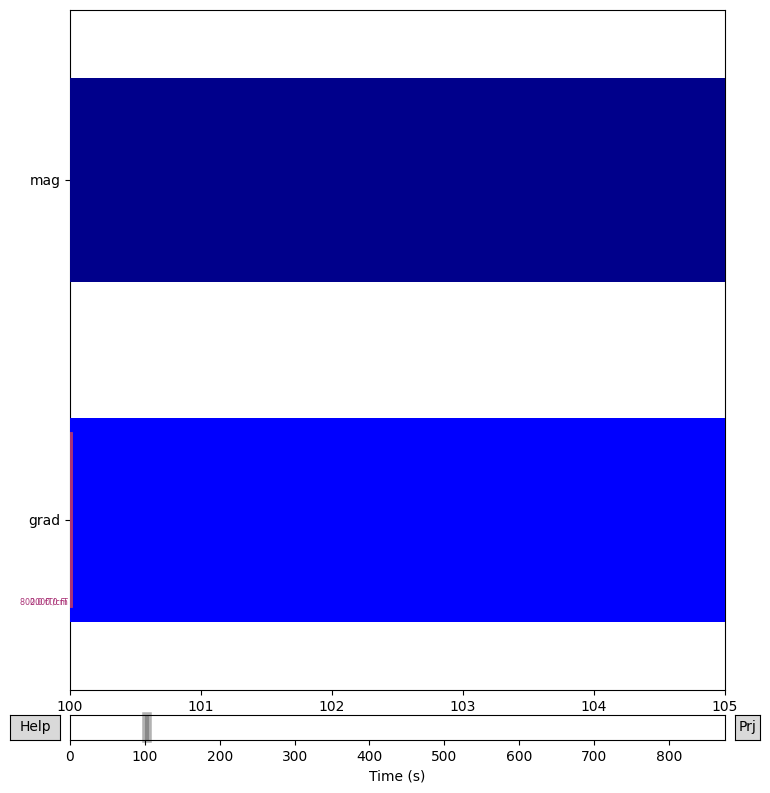

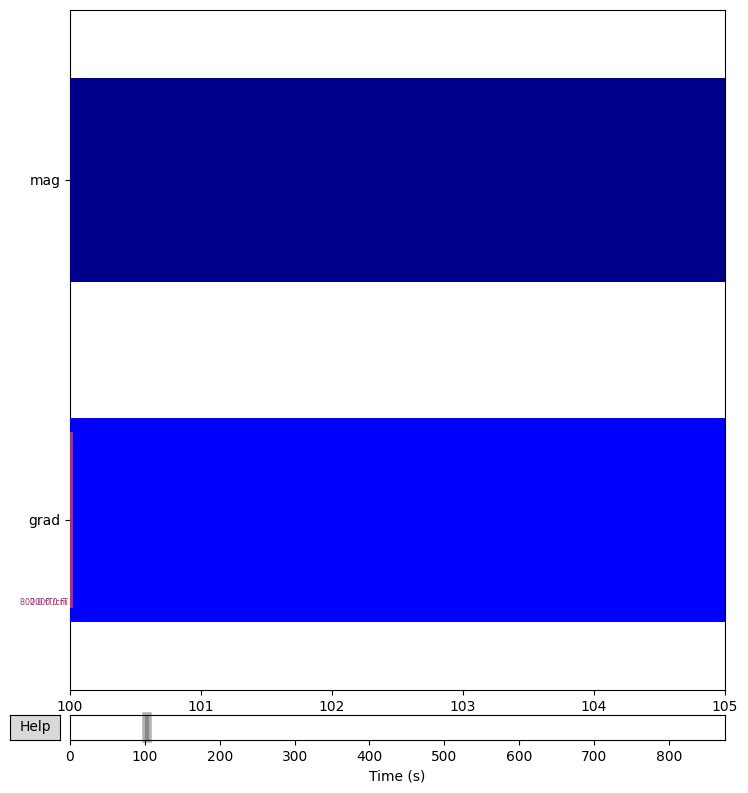

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Effective window size : 2.048 (s)


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Writing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99a01_sss.fif


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:147: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\out_path\mg99a01_sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_sss.save(fname_out, overwrite=True)


Closing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99a01_sss.fif
[done]
  File: mg99a02
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99a02.fif...
    Read a total of 6 projection items:


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:43: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99a02.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(


        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
    Range : 25000 ... 833999 =     25.000 ...   833.999 secs
Ready.
Applying low-pass filter with 40.0 Hz cutoff frequency ...
Reading 0 ... 808999  =      0.000 ...   808.999 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    4.3s finished


Scanning for bad channels in 161 intervals (5.0 sec) ...
102 of 102 magnetometer types replaced with T3.
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 86.6 mm
    Using origin -1.8, 7.2, 49.6 mm in the head frame
        Interval   1:    0.000 -    4.999
            Flat ( 2): MEG1241 MEG2641
        Interval   2:    5.000 -    9.999
            Flat ( 2): MEG1241 MEG2641
        Interval   3:   10.000 -   14.999
            Flat ( 2): MEG1241 MEG2641
        Interval   4:   15.000 -   19.999
            Flat ( 2): MEG1241 MEG2641
        Interval   5:   20.000 -   24.999
            Flat ( 2): MEG1241 MEG2641
        Interval   6:   25.000 -   29.999
            Flat ( 2): MEG1241 MEG2641
        Interval   7:   30.000 -   34.999
            Flat ( 2): MEG1241 MEG26

C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'run': run,


102 of 102 magnetometer types replaced with T3.
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:85: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ref = mne.io.read_raw_fif(raw_ref_fname_in,


    Range : 72000 ... 946999 =     72.000 ...   946.999 secs
Ready.
Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG0413', 'MEG1241', 'MEG2641']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 86.6 mm
    Using origin -1.8, 7.2, 49.6 mm in the head frame
        Using 87/95 harmonic components for    0.000  (72/80 in, 15/15 out)
    Loading raw data from disk
    Processing 80 data chunks
[done]


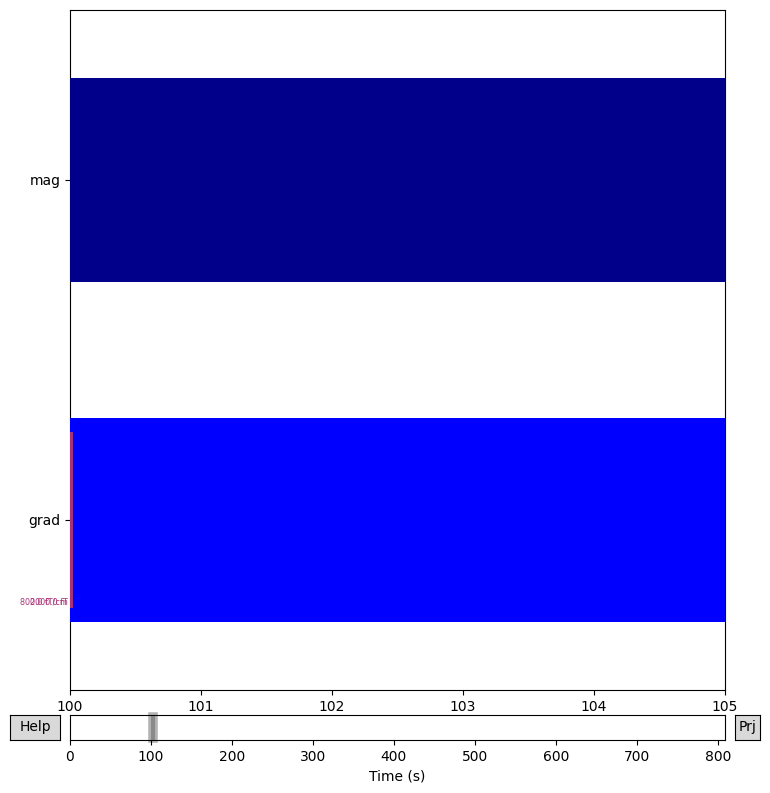

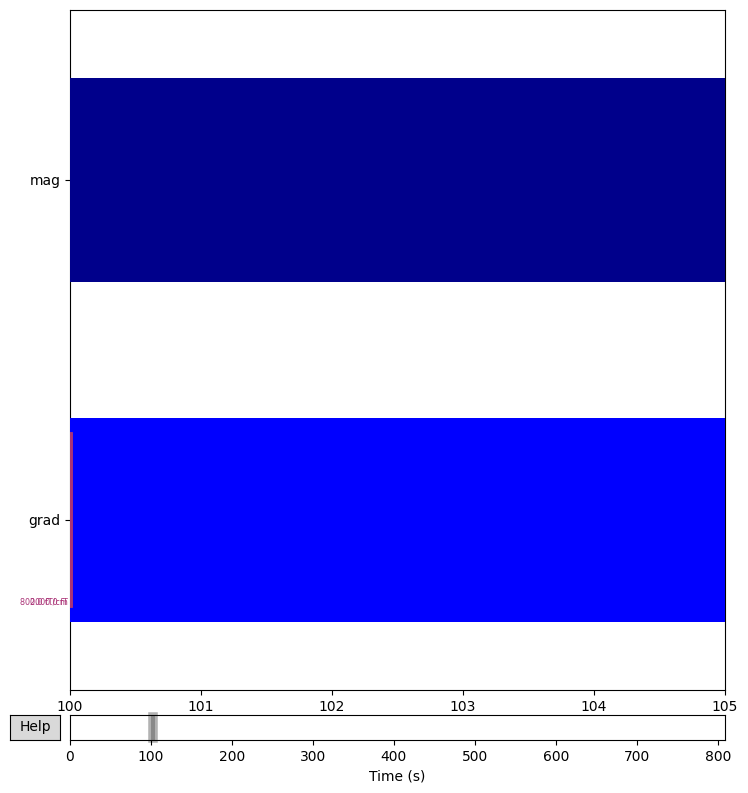

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Effective window size : 2.048 (s)
Writing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99a02_sss.fif


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:147: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\out_path\mg99a02_sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_sss.save(fname_out, overwrite=True)


Closing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99a02_sss.fif
[done]
  File: mg99a03
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99a03.fif...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:43: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99a03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(


    Range : 57000 ... 900999 =     57.000 ...   900.999 secs
Ready.
Applying low-pass filter with 40.0 Hz cutoff frequency ...
Reading 0 ... 843999  =      0.000 ...   843.999 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    5.7s finished


Scanning for bad channels in 168 intervals (5.0 sec) ...
102 of 102 magnetometer types replaced with T3.
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 86.6 mm
    Using origin -1.8, 7.2, 49.6 mm in the head frame
        Interval   1:    0.000 -    4.999
            Flat ( 2): MEG1241 MEG2641
        Interval   2:    5.000 -    9.999
            Flat ( 2): MEG1241 MEG2641
        Interval   3:   10.000 -   14.999
            Flat ( 2): MEG1241 MEG2641
        Interval   4:   15.000 -   19.999
            Flat ( 2): MEG1241 MEG2641
        Interval   5:   20.000 -   24.999
            Flat ( 2): MEG1241 MEG2641
        Interval   6:   25.000 -   29.999
            Flat ( 2): MEG1241 MEG2641
        Interval   7:   30.000 -   34.999
            Flat ( 2): MEG1241 MEG26

C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'run': run,


102 of 102 magnetometer types replaced with T3.
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:85: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ref = mne.io.read_raw_fif(raw_ref_fname_in,


    Range : 72000 ... 946999 =     72.000 ...   946.999 secs
Ready.
Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG0413', 'MEG1241', 'MEG2641']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 86.6 mm
    Using origin -1.8, 7.2, 49.6 mm in the head frame
        Using 89/95 harmonic components for    0.000  (74/80 in, 15/15 out)
    Loading raw data from disk
    Processing 84 data chunks
[done]


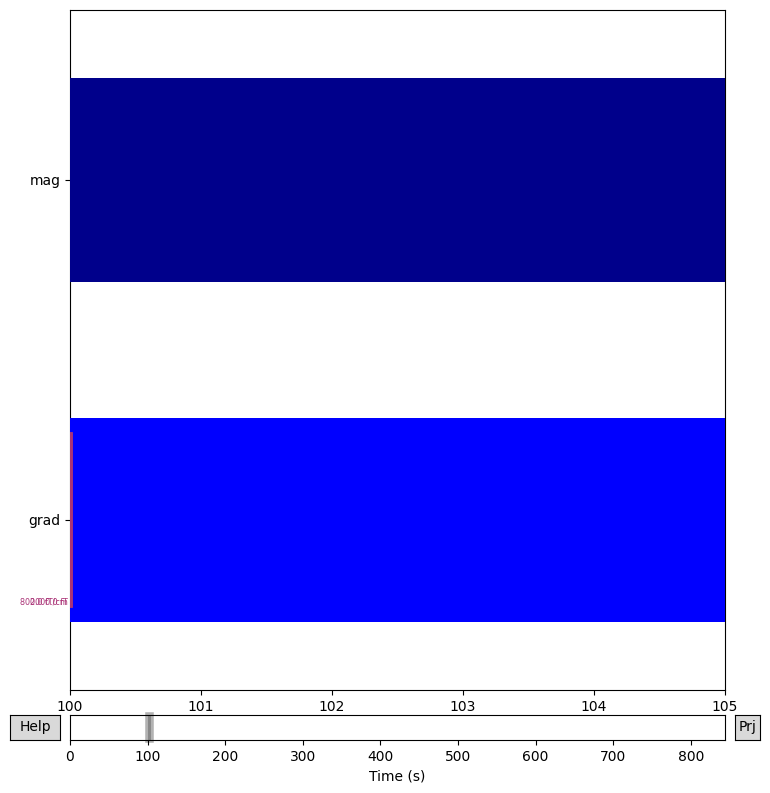

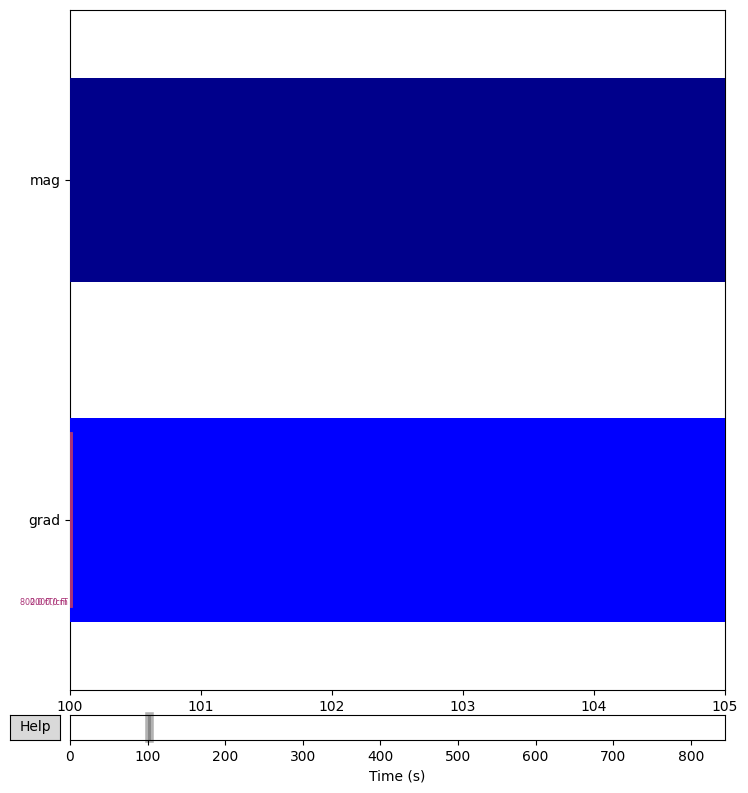

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Writing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99a03_sss.fif


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:147: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\out_path\mg99a03_sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_sss.save(fname_out, overwrite=True)


Closing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99a03_sss.fif
[done]
  File: mg99a04
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99a04.fif...


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:43: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99a04.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(


    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
    Range : 32000 ... 865999 =     32.000 ...   865.999 secs
Ready.
Applying low-pass filter with 40.0 Hz cutoff frequency ...
Reading 0 ... 833999  =      0.000 ...   833.999 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.6s finished


Scanning for bad channels in 166 intervals (5.0 sec) ...
102 of 102 magnetometer types replaced with T3.
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 86.6 mm
    Using origin -1.8, 7.2, 49.6 mm in the head frame
        Interval   1:    0.000 -    4.999
            Flat ( 2): MEG1241 MEG2641
        Interval   2:    5.000 -    9.999
            Flat ( 2): MEG1241 MEG2641
        Interval   3:   10.000 -   14.999
            Flat ( 2): MEG1241 MEG2641
        Interval   4:   15.000 -   19.999
            Flat ( 2): MEG1241 MEG2641
        Interval   5:   20.000 -   24.999
            Flat ( 2): MEG1241 MEG2641
        Interval   6:   25.000 -   29.999
            Flat ( 2): MEG1241 MEG2641
        Interval   7:   30.000 -   34.999
            Flat ( 2): MEG1241 MEG26

C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'run': run,


102 of 102 magnetometer types replaced with T3.
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:85: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ref = mne.io.read_raw_fif(raw_ref_fname_in,


    Range : 72000 ... 946999 =     72.000 ...   946.999 secs
Ready.
Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG0413', 'MEG2613', 'MEG2642', 'MEG2643', 'MEG1241', 'MEG2641']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 86.6 mm
    Using origin -1.8, 7.2, 49.6 mm in the head frame
        Using 89/95 harmonic components for    0.000  (74/80 in, 15/15 out)
    Loading raw data from disk
    Processing 83 data chunks
[done]


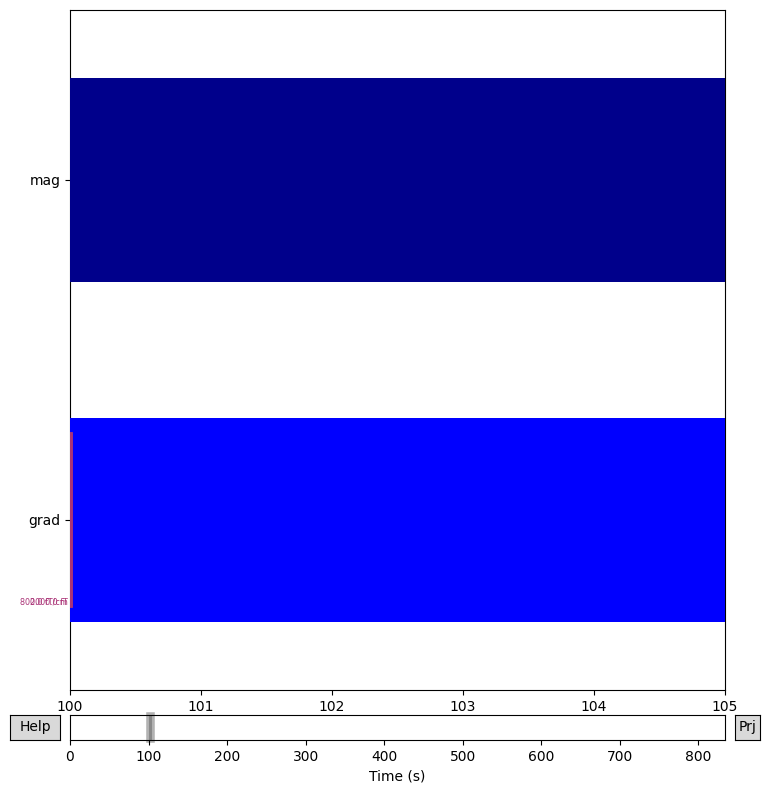

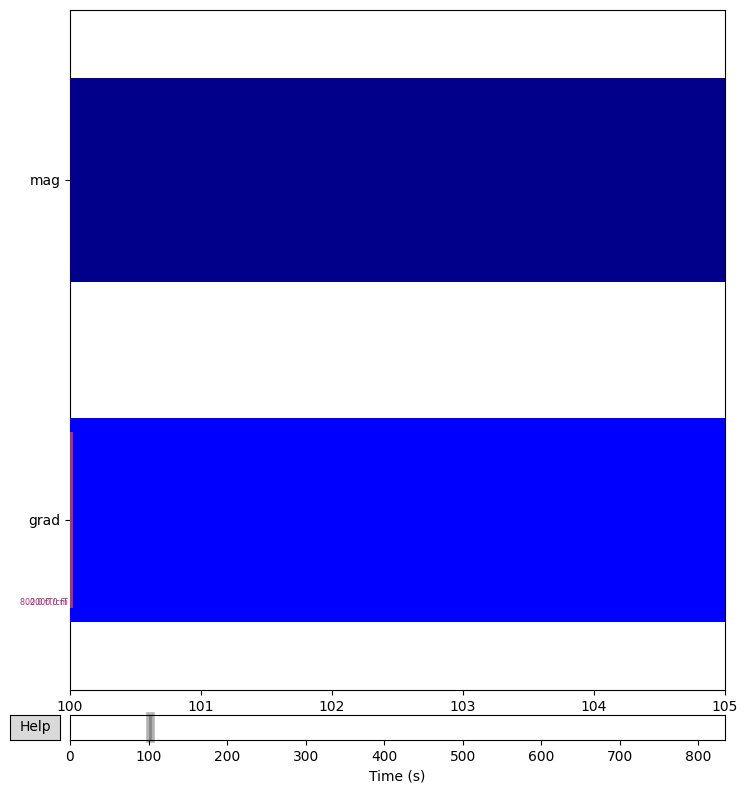

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Writing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99a04_sss.fif


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:147: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\out_path\mg99a04_sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_sss.save(fname_out, overwrite=True)


Closing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99a04_sss.fif
[done]
  File: mg99a05
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99a05.fif...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
    Range : 47000 ... 900999 =     47.000 ...   900.999 secs
Ready.
Applying low-pass filter with 40.0 Hz cutoff frequency ...


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:43: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99a05.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(


Reading 0 ... 853999  =      0.000 ...   853.999 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    4.6s finished


Scanning for bad channels in 170 intervals (5.0 sec) ...
102 of 102 magnetometer types replaced with T3.
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 86.6 mm
    Using origin -1.8, 7.2, 49.6 mm in the head frame
        Interval   1:    0.000 -    4.999
            Flat ( 2): MEG1241 MEG2641
        Interval   2:    5.000 -    9.999
            Flat ( 2): MEG1241 MEG2641
        Interval   3:   10.000 -   14.999
            Flat ( 2): MEG1241 MEG2641
        Interval   4:   15.000 -   19.999
            Flat ( 2): MEG1241 MEG2641
        Interval   5:   20.000 -   24.999
            Flat ( 2): MEG1241 MEG2641
        Interval   6:   25.000 -   29.999
            Flat ( 2): MEG1241 MEG2641
        Interval   7:   30.000 -   34.999
            Flat ( 2): MEG1241 MEG26

C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'run': run,


102 of 102 magnetometer types replaced with T3.
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:85: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ref = mne.io.read_raw_fif(raw_ref_fname_in,


    Range : 72000 ... 946999 =     72.000 ...   946.999 secs
Ready.
Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG0413', 'MEG1932', 'MEG2613', 'MEG2642', 'MEG2643', 'MEG1241', 'MEG2641']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 86.6 mm
    Using origin -1.8, 7.2, 49.6 mm in the head frame
        Using 87/95 harmonic components for    0.000  (72/80 in, 15/15 out)
    Loading raw data from disk
    Processing 85 data chunks
[done]


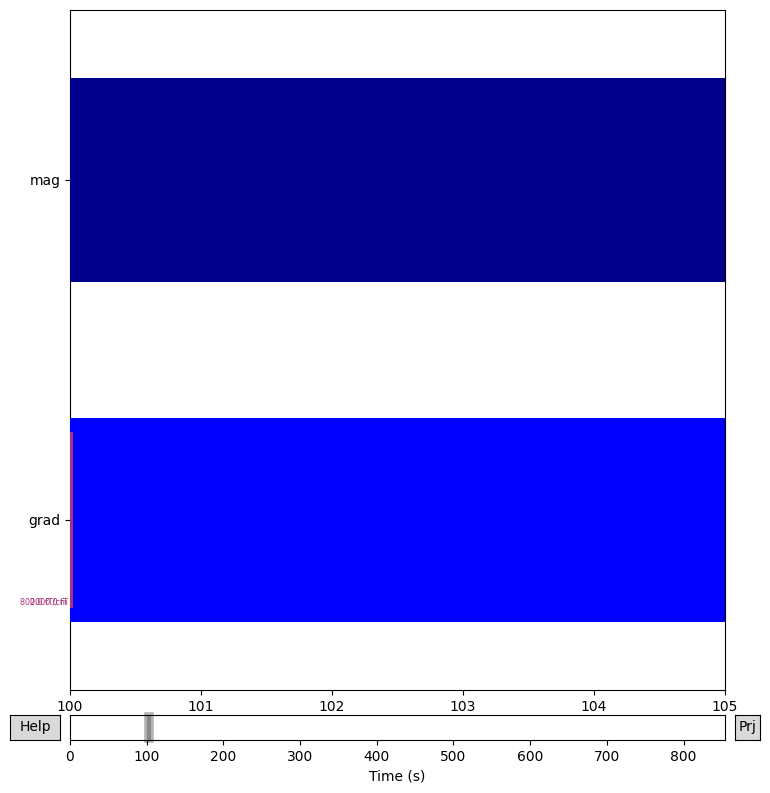

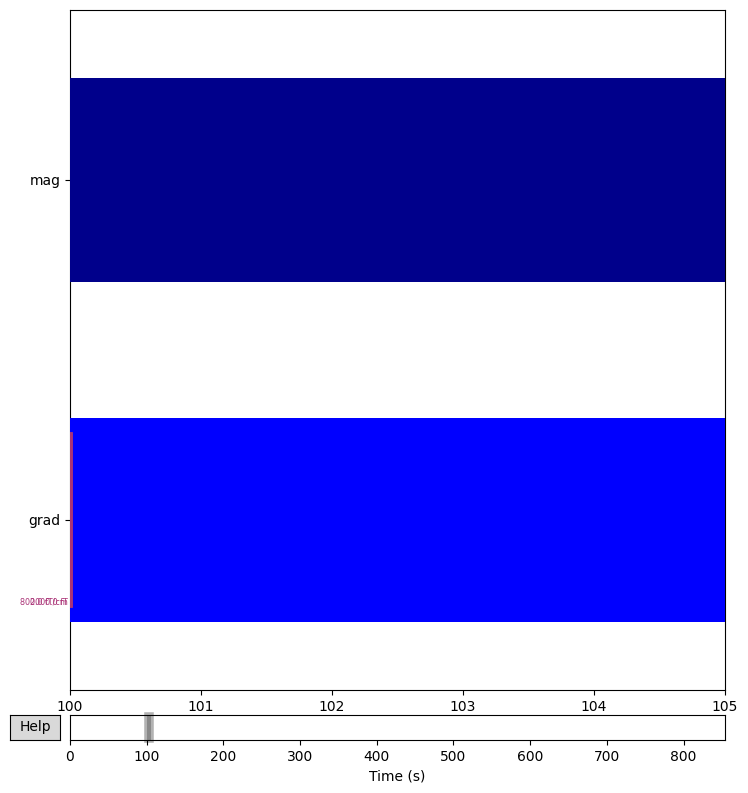

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Effective window size : 2.048 (s)


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Writing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99a05_sss.fif


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:147: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\out_path\mg99a05_sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_sss.save(fname_out, overwrite=True)


Closing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99a05_sss.fif
[done]
  File: mg99a06
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99a06.fif...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:43: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99a06.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(


    Range : 28000 ... 814999 =     28.000 ...   814.999 secs
Ready.
Applying low-pass filter with 40.0 Hz cutoff frequency ...
Reading 0 ... 786999  =      0.000 ...   786.999 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    4.1s finished


Scanning for bad channels in 157 intervals (5.0 sec) ...
102 of 102 magnetometer types replaced with T3.
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 86.6 mm
    Using origin -1.8, 7.2, 49.6 mm in the head frame
        Interval   1:    0.000 -    4.999
            Flat ( 2): MEG1241 MEG2641
        Interval   2:    5.000 -    9.999
            Flat ( 2): MEG1241 MEG2641
        Interval   3:   10.000 -   14.999
            Flat ( 2): MEG1241 MEG2641
        Interval   4:   15.000 -   19.999
            Flat ( 2): MEG1241 MEG2641
        Interval   5:   20.000 -   24.999
            Flat ( 2): MEG1241 MEG2641
        Interval   6:   25.000 -   29.999
            Flat ( 2): MEG1241 MEG2641
        Interval   7:   30.000 -   34.999
            Flat ( 2): MEG1241 MEG26

C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'run': run,


102 of 102 magnetometer types replaced with T3.
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:85: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ref = mne.io.read_raw_fif(raw_ref_fname_in,


    Range : 72000 ... 946999 =     72.000 ...   946.999 secs
Ready.
Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG0413', 'MEG0412', 'MEG2613', 'MEG2642', 'MEG2643', 'MEG1241', 'MEG2641']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 86.6 mm
    Using origin -1.8, 7.2, 49.6 mm in the head frame
        Using 87/95 harmonic components for    0.000  (72/80 in, 15/15 out)
    Loading raw data from disk
    Processing 78 data chunks
[done]


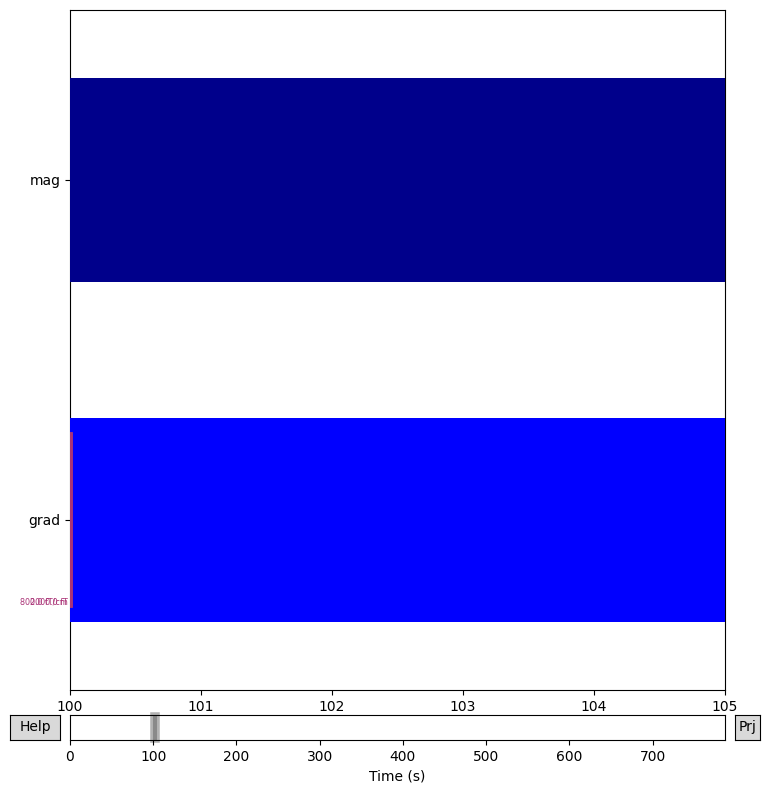

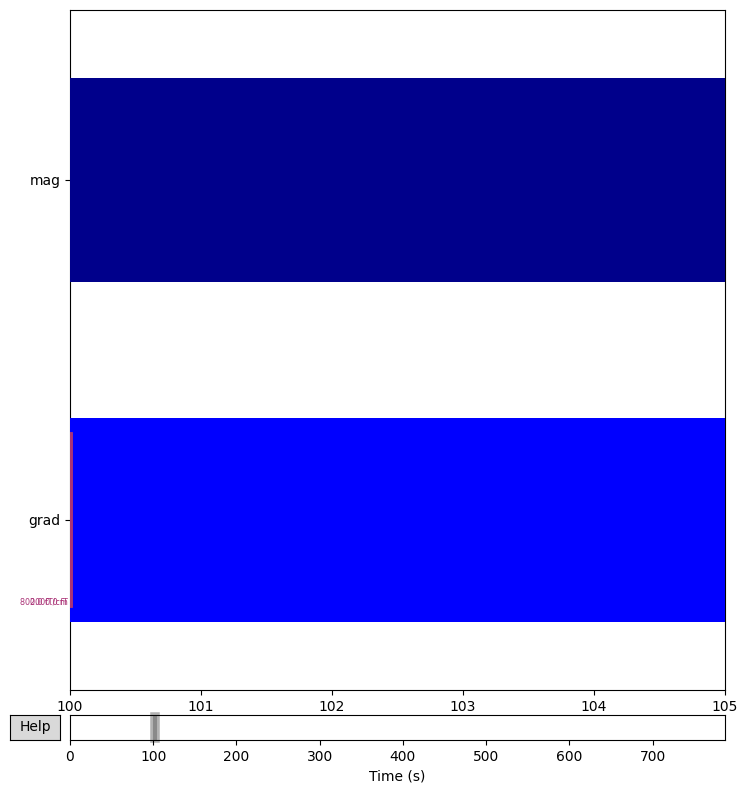

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Effective window size : 2.048 (s)
Writing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99a06_sss.fif


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:147: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\out_path\mg99a06_sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_sss.save(fname_out, overwrite=True)


Closing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99a06_sss.fif
[done]
  File: mg99b07
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99b07.fif...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
    Range : 168000 ... 1007999 =    168.000 ...  1007.999 secs


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:43: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99b07.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(


Ready.
Applying low-pass filter with 40.0 Hz cutoff frequency ...
Reading 0 ... 839999  =      0.000 ...   839.999 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    4.5s finished


Scanning for bad channels in 168 intervals (5.0 sec) ...
102 of 102 magnetometer types replaced with T3.
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 87.8 mm
    Using origin -2.9, 9.6, 47.4 mm in the head frame
        Interval   1:    0.000 -    4.999
            Flat ( 2): MEG1241 MEG2641
        Interval   2:    5.000 -    9.999
            Flat ( 2): MEG1241 MEG2641
        Interval   3:   10.000 -   14.999
            Flat ( 2): MEG1241 MEG2641
        Interval   4:   15.000 -   19.999
            Flat ( 2): MEG1241 MEG2641
        Interval   5:   20.000 -   24.999
            Flat ( 2): MEG1241 MEG2641
        Interval   6:   25.000 -   29.999
            Flat ( 2): MEG1241 MEG2641
        Interval   7:   30.000 -   34.999
            Flat ( 2): MEG1241 MEG26

C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'run': run,


102 of 102 magnetometer types replaced with T3.
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:85: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ref = mne.io.read_raw_fif(raw_ref_fname_in,


    Range : 72000 ... 946999 =     72.000 ...   946.999 secs
Ready.
Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG2041', 'MEG2142', 'MEG1241', 'MEG2641']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 87.8 mm
    Using origin -2.9, 9.6, 47.4 mm in the head frame
        Using 87/95 harmonic components for    0.000  (72/80 in, 15/15 out)
    Loading raw data from disk
    Processing 84 data chunks
[done]


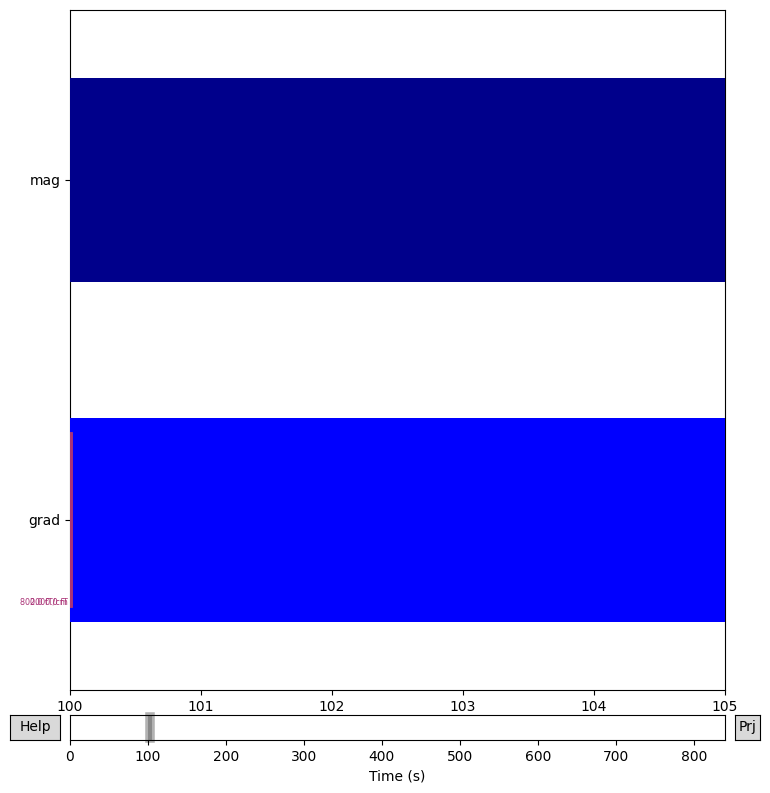

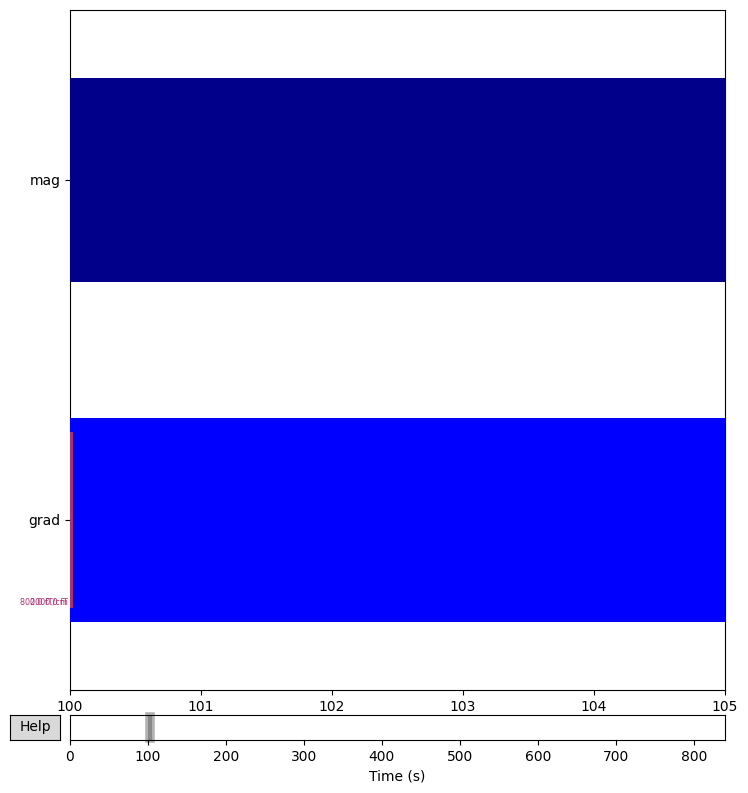

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Effective window size : 2.048 (s)
Writing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99b07_sss.fif


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:147: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\out_path\mg99b07_sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_sss.save(fname_out, overwrite=True)


Closing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99b07_sss.fif
[done]
  File: mg99b08
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99b08.fif...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:43: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99b08.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(


    Range : 42000 ... 801999 =     42.000 ...   801.999 secs
Ready.
Applying low-pass filter with 40.0 Hz cutoff frequency ...
Reading 0 ... 759999  =      0.000 ...   759.999 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    3.9s finished


Scanning for bad channels in 152 intervals (5.0 sec) ...
102 of 102 magnetometer types replaced with T3.
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 87.8 mm
    Using origin -2.9, 9.6, 47.4 mm in the head frame
        Interval   1:    0.000 -    4.999
            Flat ( 2): MEG1241 MEG2641
        Interval   2:    5.000 -    9.999
            Flat ( 2): MEG1241 MEG2641
        Interval   3:   10.000 -   14.999
            Flat ( 2): MEG1241 MEG2641
        Interval   4:   15.000 -   19.999
            Flat ( 2): MEG1241 MEG2641
        Interval   5:   20.000 -   24.999
            Flat ( 2): MEG1241 MEG2641
        Interval   6:   25.000 -   29.999
            Flat ( 2): MEG1241 MEG2641
        Interval   7:   30.000 -   34.999
            Flat ( 2): MEG1241 MEG26

C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'run': run,


102 of 102 magnetometer types replaced with T3.
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
    Range : 72000 ... 946999 =     72.000 ...   946.999 secs
Ready.
Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG2011', 'MEG2511', 'MEG1241', 'MEG2641']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:85: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ref = mne.io.read_raw_fif(raw_ref_fname_in,


        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 87.8 mm
    Using origin -2.9, 9.6, 47.4 mm in the head frame
        Using 90/95 harmonic components for    0.000  (75/80 in, 15/15 out)
    Loading raw data from disk
    Processing 76 data chunks
[done]


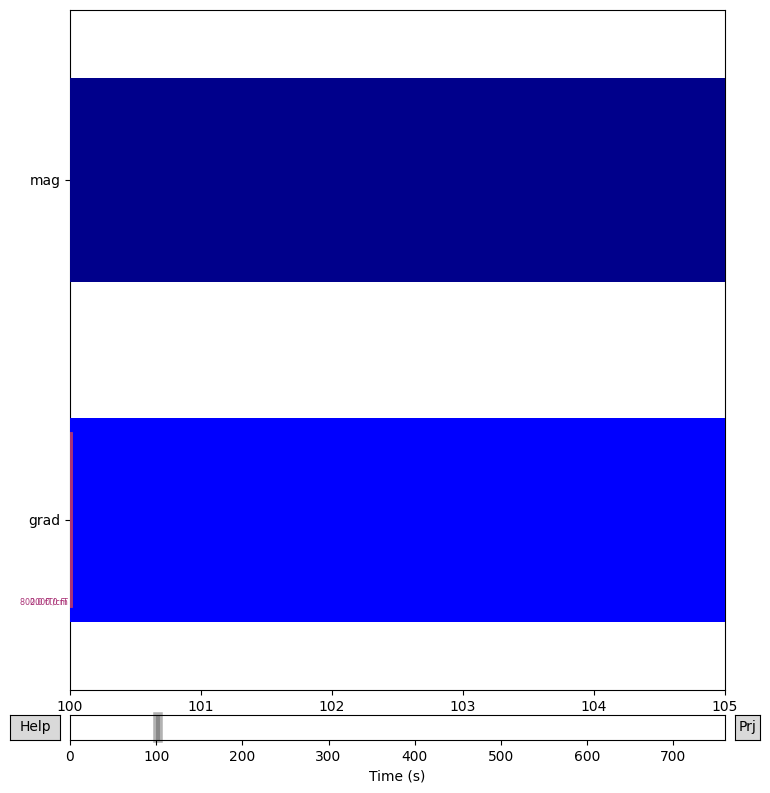

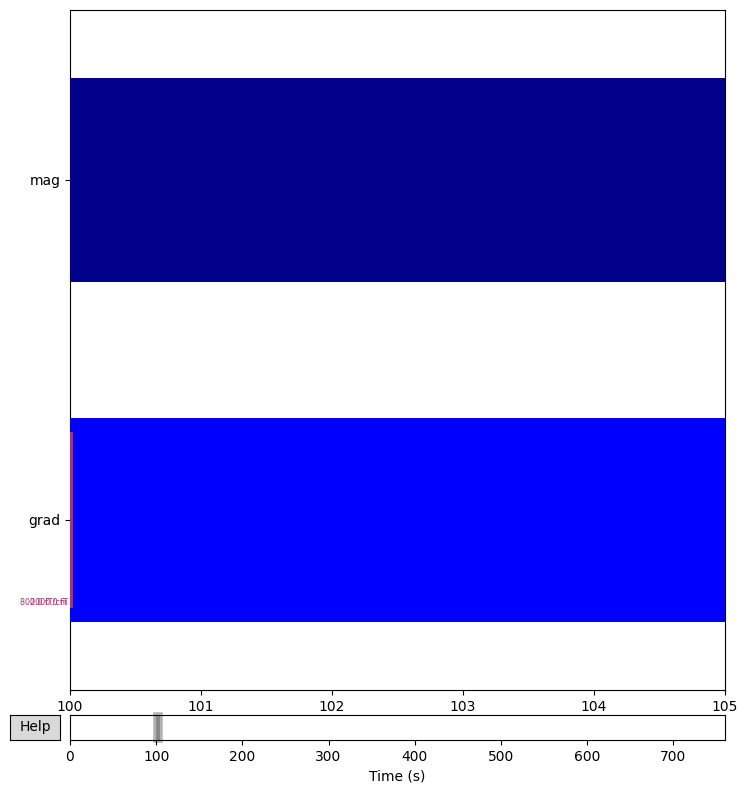

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Writing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99b08_sss.fif


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:147: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\out_path\mg99b08_sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_sss.save(fname_out, overwrite=True)


Closing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99b08_sss.fif
[done]
  File: mg99b09
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99b09.fif...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:43: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99b09.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(


    Range : 58000 ... 850999 =     58.000 ...   850.999 secs
Ready.
Applying low-pass filter with 40.0 Hz cutoff frequency ...
Reading 0 ... 792999  =      0.000 ...   792.999 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    4.3s finished


Scanning for bad channels in 158 intervals (5.0 sec) ...
102 of 102 magnetometer types replaced with T3.
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 87.8 mm
    Using origin -2.9, 9.6, 47.4 mm in the head frame
        Interval   1:    0.000 -    4.999
            Flat ( 2): MEG1241 MEG2641
        Interval   2:    5.000 -    9.999
            Flat ( 2): MEG1241 MEG2641
        Interval   3:   10.000 -   14.999
            Flat ( 2): MEG1241 MEG2641
        Interval   4:   15.000 -   19.999
            Flat ( 2): MEG1241 MEG2641
        Interval   5:   20.000 -   24.999
            Flat ( 2): MEG1241 MEG2641
        Interval   6:   25.000 -   29.999
            Flat ( 2): MEG1241 MEG2641
        Interval   7:   30.000 -   34.999
            Flat ( 2): MEG1241 MEG26

C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'run': run,


102 of 102 magnetometer types replaced with T3.
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:85: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ref = mne.io.read_raw_fif(raw_ref_fname_in,


    Range : 72000 ... 946999 =     72.000 ...   946.999 secs
Ready.
Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG1423', 'MEG2011', 'MEG2511', 'MEG1241', 'MEG2641']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 87.8 mm
    Using origin -2.9, 9.6, 47.4 mm in the head frame
        Using 87/95 harmonic components for    0.000  (72/80 in, 15/15 out)
    Loading raw data from disk
    Processing 79 data chunks
[done]


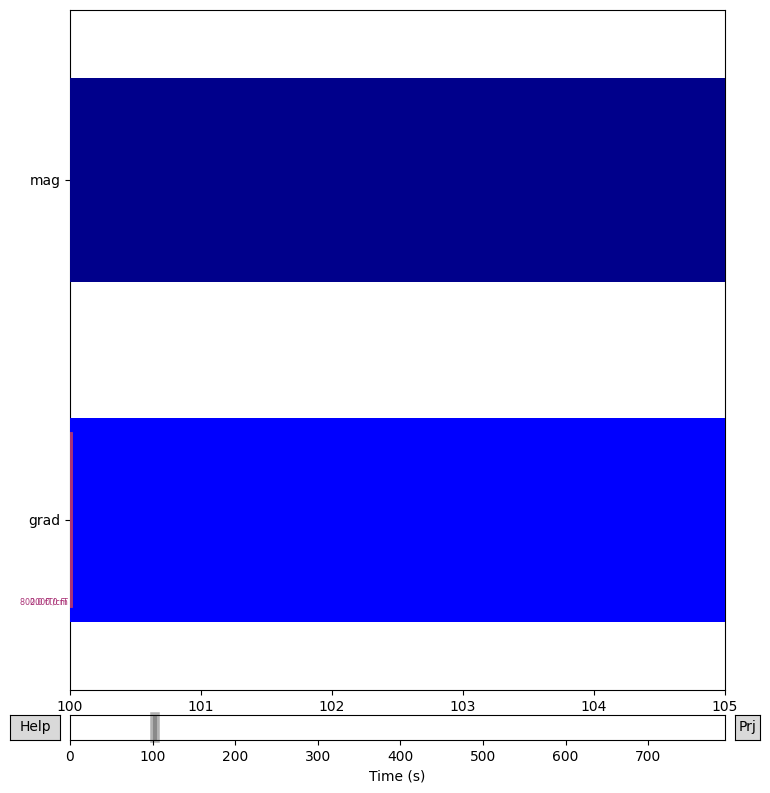

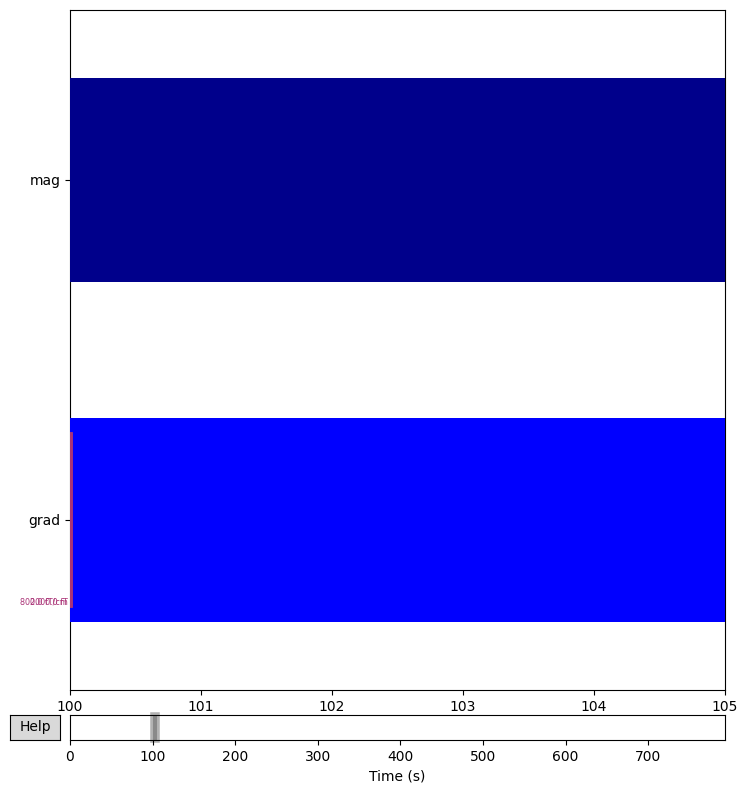

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Effective window size : 2.048 (s)
Writing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99b09_sss.fif


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:147: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\out_path\mg99b09_sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_sss.save(fname_out, overwrite=True)


Closing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99b09_sss.fif
[done]
  File: mg99b10
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99b10.fif...


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:43: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99b10.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(


    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
    Range : 30000 ... 810999 =     30.000 ...   810.999 secs
Ready.
Applying low-pass filter with 40.0 Hz cutoff frequency ...
Reading 0 ... 780999  =      0.000 ...   780.999 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    4.0s finished


Scanning for bad channels in 156 intervals (5.0 sec) ...
102 of 102 magnetometer types replaced with T3.
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 87.8 mm
    Using origin -2.9, 9.6, 47.4 mm in the head frame
        Interval   1:    0.000 -    4.999
            Flat ( 2): MEG1241 MEG2641
        Interval   2:    5.000 -    9.999
            Flat ( 2): MEG1241 MEG2641
        Interval   3:   10.000 -   14.999
            Flat ( 2): MEG1241 MEG2641
        Interval   4:   15.000 -   19.999
            Flat ( 2): MEG1241 MEG2641
        Interval   5:   20.000 -   24.999
            Flat ( 2): MEG1241 MEG2641
        Interval   6:   25.000 -   29.999
            Flat ( 2): MEG1241 MEG2641
        Interval   7:   30.000 -   34.999
            Flat ( 2): MEG1241 MEG26

C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'run': run,


102 of 102 magnetometer types replaced with T3.
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif...


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:85: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ref = mne.io.read_raw_fif(raw_ref_fname_in,


    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
    Range : 72000 ... 946999 =     72.000 ...   946.999 secs
Ready.
Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG0413', 'MEG0823', 'MEG1241', 'MEG2641']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 87.8 mm
    Using origin -2.9, 9.6, 47.4 mm in the head frame
        Using 87/95 harmonic components for    0.000  (72/80 in, 15/15 out)
    Loading raw data from disk
    Processing 78 data chunks
[done]


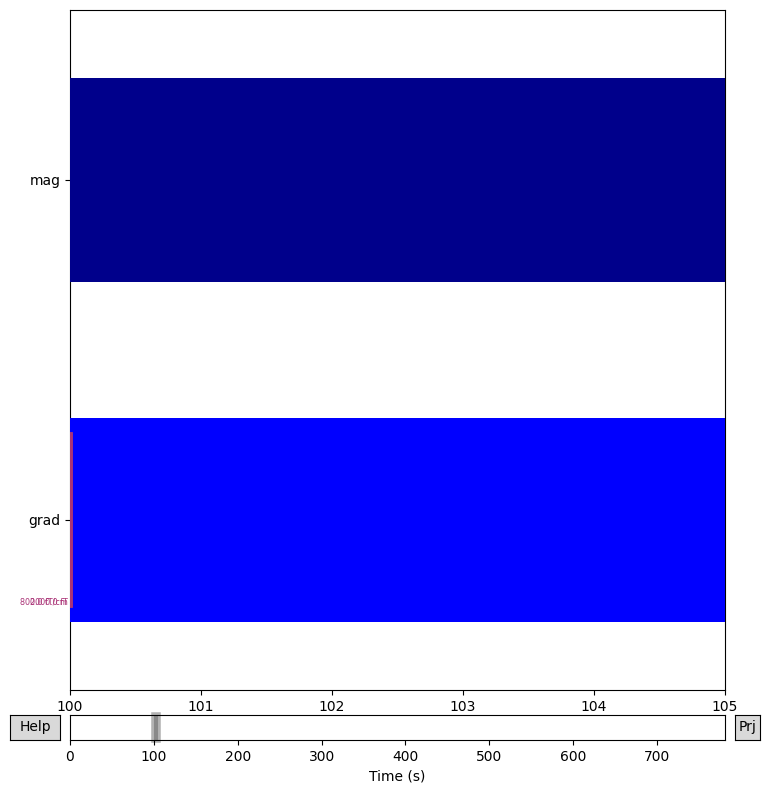

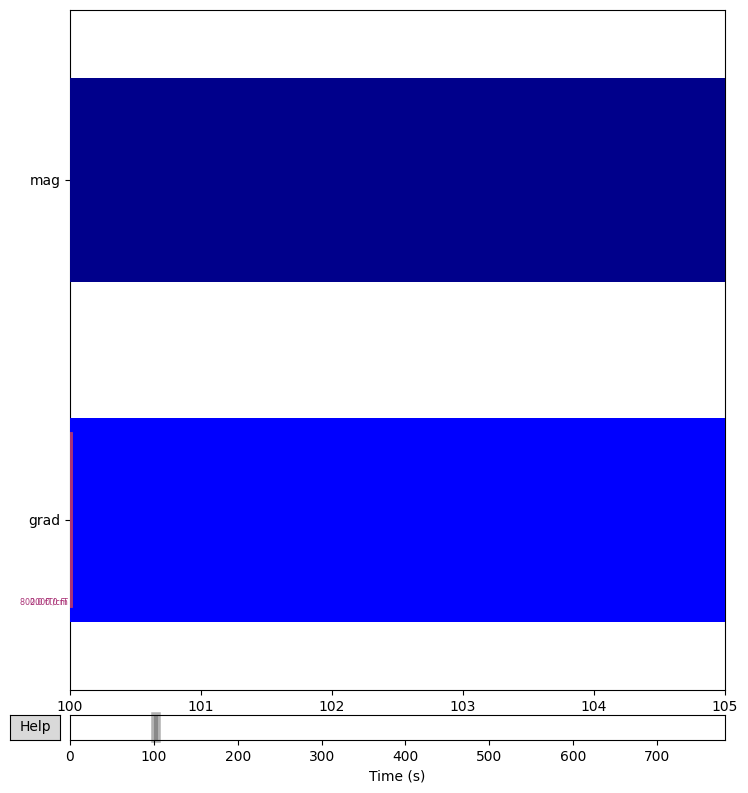

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Effective window size : 2.048 (s)
Writing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99b10_sss.fif


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:147: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\out_path\mg99b10_sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_sss.save(fname_out, overwrite=True)


Closing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99b10_sss.fif
[done]
  File: mg99b11
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99b11.fif...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:43: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99b11.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(


    Range : 24000 ... 782999 =     24.000 ...   782.999 secs
Ready.
Applying low-pass filter with 40.0 Hz cutoff frequency ...
Reading 0 ... 758999  =      0.000 ...   758.999 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    3.9s finished


Scanning for bad channels in 151 intervals (5.0 sec) ...
102 of 102 magnetometer types replaced with T3.
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 87.8 mm
    Using origin -2.9, 9.6, 47.4 mm in the head frame
        Interval   1:    0.000 -    4.999
            Flat ( 2): MEG1241 MEG2641
        Interval   2:    5.000 -    9.999
            Flat ( 2): MEG1241 MEG2641
        Interval   3:   10.000 -   14.999
            Flat ( 2): MEG1241 MEG2641
        Interval   4:   15.000 -   19.999
            Flat ( 2): MEG1241 MEG2641
        Interval   5:   20.000 -   24.999
            Flat ( 2): MEG1241 MEG2641
        Interval   6:   25.000 -   29.999
            Flat ( 2): MEG1241 MEG2641
        Interval   7:   30.000 -   34.999
            Flat ( 2): MEG1241 MEG26

C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'run': run,


102 of 102 magnetometer types replaced with T3.
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif...


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:85: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ref = mne.io.read_raw_fif(raw_ref_fname_in,


    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
    Range : 72000 ... 946999 =     72.000 ...   946.999 secs
Ready.
Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG0413', 'MEG1241', 'MEG2641']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 87.8 mm
    Using origin -2.9, 9.6, 47.4 mm in the head frame
        Using 87/95 harmonic components for    0.000  (72/80 in, 15/15 out)
    Loading raw data from disk
    Processing 75 data chunks
[done]


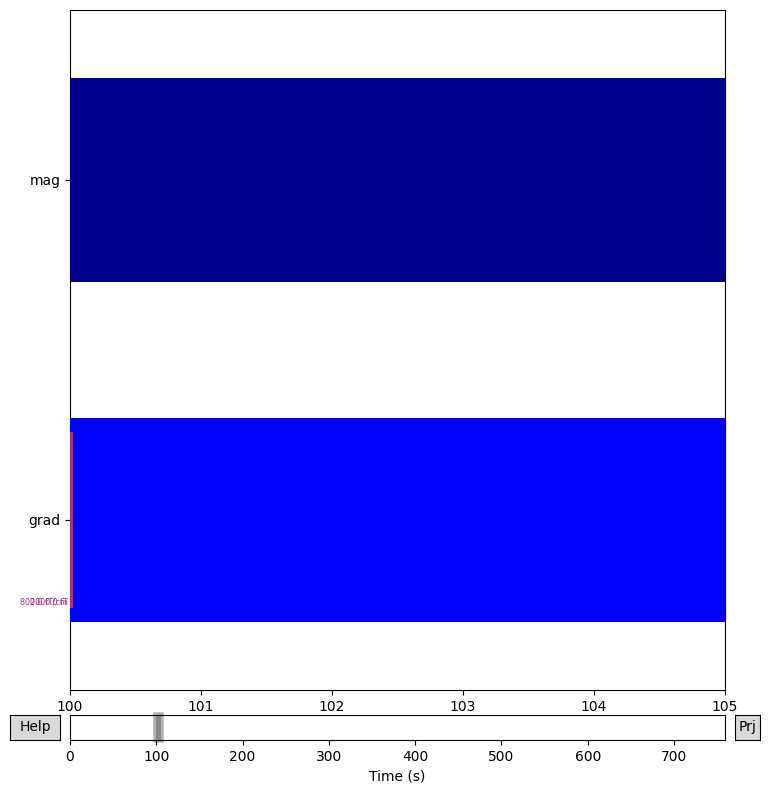

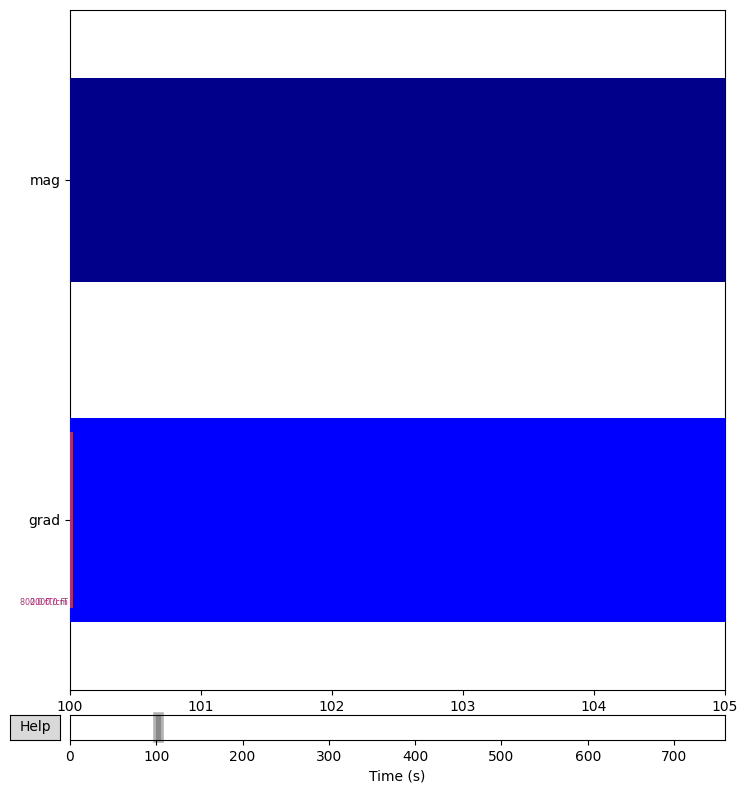

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Effective window size : 2.048 (s)
Writing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99b11_sss.fif


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:147: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\out_path\mg99b11_sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_sss.save(fname_out, overwrite=True)


Closing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99b11_sss.fif
[done]
  File: mg99b12
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99b12.fif...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:43: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99b12.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(


    Range : 48000 ... 799999 =     48.000 ...   799.999 secs
Ready.
Applying low-pass filter with 40.0 Hz cutoff frequency ...
Reading 0 ... 751999  =      0.000 ...   751.999 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    3.9s finished


Scanning for bad channels in 150 intervals (5.0 sec) ...
102 of 102 magnetometer types replaced with T3.
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 87.8 mm
    Using origin -2.9, 9.6, 47.4 mm in the head frame
        Interval   1:    0.000 -    4.999
            Flat ( 2): MEG1241 MEG2641
        Interval   2:    5.000 -    9.999
            Flat ( 2): MEG1241 MEG2641
        Interval   3:   10.000 -   14.999
            Flat ( 2): MEG1241 MEG2641
        Interval   4:   15.000 -   19.999
            Flat ( 2): MEG1241 MEG2641
        Interval   5:   20.000 -   24.999
            Flat ( 2): MEG1241 MEG2641
        Interval   6:   25.000 -   29.999
            Flat ( 2): MEG1241 MEG2641
        Interval   7:   30.000 -   34.999
            Flat ( 2): MEG1241 MEG26

C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'run': run,


102 of 102 magnetometer types replaced with T3.
Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
    Range : 72000 ... 946999 =     72.000 ...   946.999 secs
Ready.
Maxwell filtering raw data


C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:85: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ref = mne.io.read_raw_fif(raw_ref_fname_in,


    Bad MEG channels being reconstructed: ['MEG0413', 'MEG1241', 'MEG2641']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 87.8 mm
    Using origin -2.9, 9.6, 47.4 mm in the head frame
        Using 89/95 harmonic components for    0.000  (74/80 in, 15/15 out)
    Loading raw data from disk
    Processing 75 data chunks
[done]


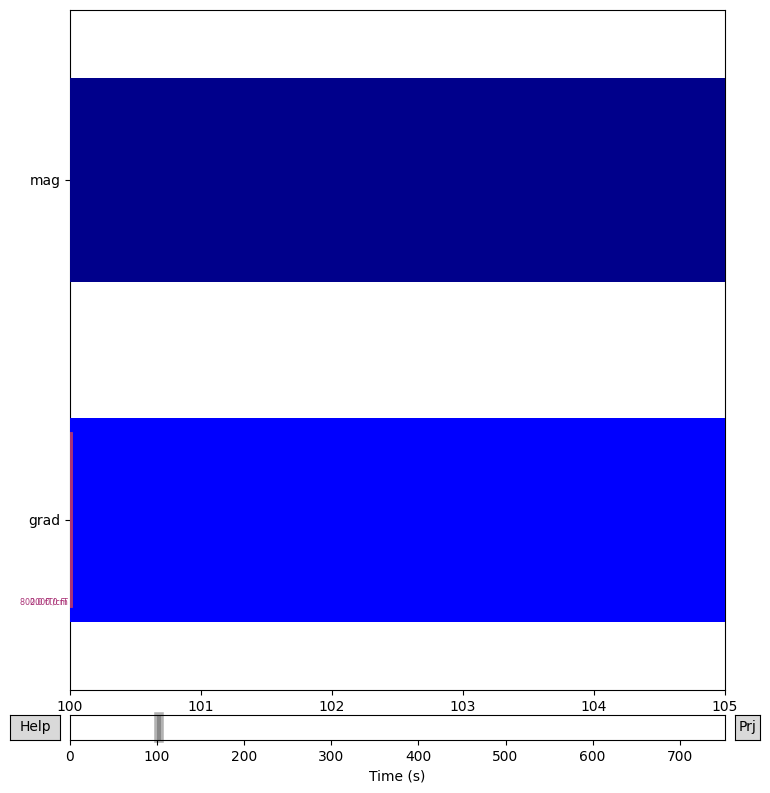

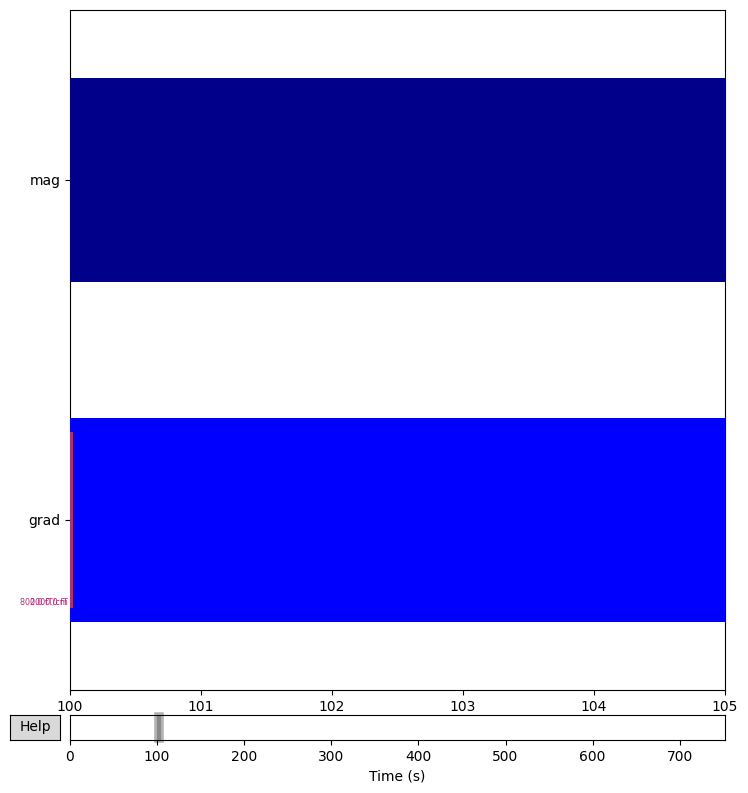

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Writing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99b12_sss.fif


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\qiaol\AppData\Local\Temp\ipykernel_12292\1239097975.py:147: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\out_path\mg99b12_sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_sss.save(fname_out, overwrite=True)


Closing D:\projects\WM_GRID\DATA\mg99a\out_path\mg99b12_sss.fif
[done]


In [7]:
# %load config.py
"""
===========
Config file
===========

Configurate the parameters of the study.
"""
for subject_id in subject_list[:1]:

    # =============================================================================
    # SESSION-SPECIFIC SETTINGS
    # =============================================================================

    # Set filename based on experiment number
    file_exts = ['%sa01',
                     '%sa02',
                     '%sa03',
                     '%sa04',
                     '%sa05',
                     '%sa06',
                     '%sb07',
                     '%sb08',
                     '%sb09',
                     '%sb10',
                     '%sb11',
                     '%sb12']

    file_names = [f % (subject_id) for f in file_exts]


    # =============================================================================
    # GENERAL SETTINGS
    # =============================================================================

    # Set out_path folder or create it if it doesn't exist
    out_path = op.join(data_path, "out_path")
    if not op.exists(out_path):
        os.mkdir(out_path)


    # =============================================================================
    # MAXWELL FILTERING SETTINGS
    # =============================================================================

    # Set filtering method
    method='sss'
    if method == 'tsss':
        st_duration = 10
    else:
        st_duration = None


    # =============================================================================
    # FILTERING AND DOWNSAMPLING SETTINGS
    # =============================================================================

    # Filter and resampling params
    l_freq = 1
    h_freq = 40
    sfreq = 200


    # =============================================================================
    # ICA SETTINGS
    # =============================================================================

    ica_method = 'fastica'
    n_components = 0.99
    max_iter = 800
    random_state = 1688


    # =============================================================================
    # RUN
    # =============================================================================

    run_maxwell_filter(method=method)


    # artifact_annotation()

    # run_events()
    
    # run_ica(max_iter = max_iter, 
    #    n_components = n_components, 
    #    random_state = random_state)

In [ ]:
# %load 06-apply_ica.py
"""
===============
06. Apply ICA
===============

This relies on the ICAs computed in 05-run_ica.py

Open issues:
    1. Should we automitaze EOG- and ECG-related ICs detection?
    -> up to Ling and Oscar. Do auto and cross-check afterwards
    2. Add plots?
    -> no
    3. How many comps per type should we remove?
    -> 1-2 each (if any). 2-5 in total
    4. Apply on concatenated data? -> Yes
    
"""

def apply_ica(meg_ica_eog = [], meg_ica_ecg = []):

    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")
    
    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        raw_fname_in = op.join(out_path,
                               file_name + '_artif.fif')
        raw = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')
        
        # Show original signal

        chs = ['MEG0311', 'MEG0121', 'MEG1211', 'MEG1411', 'EOG001','EOG002']
        chan_idxs = [raw.ch_names.index(ch) for ch in chs]
        fig1 = raw.plot(order=chan_idxs,
                       duration=50,
                       start=100)        
        fname_fig1 = op.join(out_path,
                            '06_r%s_ica_raw0.png' % run)
        fig1.savefig(fname_fig1)
        plt.close()
        
        '''
        # Add figure to report
        pdf.add_page()
        pdf.set_font('helvetica', 'B', 16)
        pdf.cell(0, 10, file_name)
        pdf.ln(20)
        pdf.set_font('helvetica', 'B', 12)
        pdf.cell(0, 10, 'Timecourse of input data', 'B', ln=1)
        pdf.image(fname_fig1, 0, 45, pdf.epw)
        '''
        ###################
        # ICA on MEG data #
        ###################
        
        if [meg_ica_eog + meg_ica_ecg] != []:
            
            # Restore ICA solution from fif file
            ica_meg_fname = op.join(out_path,
                                file_name[0:14] + 'ALL-ica_meg.fif')
            ica_meg = read_ica(ica_meg_fname)
            
            # Select EOG- and ECG-related components for exclusion
            ica_meg.exclude.extend(meg_ica_eog + meg_ica_ecg)
            
            # # Plot excluded ICs
            # if meg_ica_eog != []:
            #     # Display component properties
            #     fig = ica.plot_properties(raw, 
            #                               picks=meg_ica_eog)
            #     for i in range(len(fig)):
            #         fname_fig = op.join(out_path, 
            #                             "04_r%s_ica_meg_eog%d.png" % (run,i))
            #         fig[i].savefig(fname_fig)
            #         plt.close(fig[i])
            # if meg_ica_ecg != []:
            #     # Display component properties
            #     fig = ica.plot_properties(raw, 
            #                               picks=meg_ica_ecg)
            #     for i in range(len(fig)):
            #         fname_fig = op.join(out_path, 
            #                             "04_r%s_ica_meg_ecg%d.png" % (run,i))
            #         fig[i].savefig(fname_fig)
            #         plt.close(fig[i])
            
        
        ###################
        
        # Remove selected components from the signal  #TODO: @Ling why "apply" is done in two different steps?
        raw_ica = raw.copy()
        ica_meg.apply(raw_ica)
        
        # Show cleaned signal
        fig_ica = raw_ica.plot(order=chan_idxs,
                               duration=50,
                               start=100)        
        fname_fig_ica = op.join(out_path,
                                '06_r%s_ica_rawICA.png' % run)
        fig_ica.savefig(fname_fig_ica)
        plt.close()
        
        '''
        # Add figures to report
        pdf.ln(120)
        pdf.cell(0, 10, 'Timecourse of output data', 'B', ln=1)
        pdf.image(fname_fig_ica, 0, 175, pdf.epw)
        '''
        # Save cleaned raw data
        fname_out = op.join(out_path,
                            file_name + '_ica.fif')
        raw_ica.save(fname_out,overwrite=True)
    
    # Save report  #TODO: add note about removed ICs
    pdf.output(op.join(out_path,
                       'apply_ica' + '-report.pdf'))
    
    # sys.stdout.close()      # close log file
    # sys.stdout = stdout_obj # restore command prompt




NameError: name 'raw' is not defined

In [ ]:
# %load 07-make_epochs.py
"""
====================
07. Make epochs
====================

Open issues:
    - baseline correction -> removed
    - apply (SSP) projections?
    - separate MEG and EEG in two different FIF files?
    - Exp.2: separate VG and replay in two different files?
    - detrand required for EEG data: when do we apply it? to epochs or to events?
    - remove peak-to-peak rejection?
    
"""


def run_epochs():

    # stdout_obj = sys.stdout                 # store original stdout 
    # sys.stdout = open(op.join(out_path,     # open log file
    #                            os.path.basename(__file__) + "_%s.txt" % (site_id+subject_id)),'w')
    
    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")
    
    print("Processing subject: %s" % subject_id)
    
    # Create empty lists
    raw_list = list()
    events_list = list()
    metadata_list = list()
    
    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        raw_fname_in = op.join(out_path,
                               file_name + '_ica.fif')
        raw_tmp = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=False, 
            verbose='error')
        
        # Read events
        events_tmp = mne.read_events(op.join(out_path,
                                             file_name + '-eve.fif'))                           
        # Read metadata
        metadata_tmp = pd.read_csv(op.join(out_path,
                                           file_name + '-meta.csv'))
        
        # Append read data to list
        raw_list.append(raw_tmp)
        events_list.append(events_tmp)
        metadata_list.append(metadata_tmp)

    # Concatenate raw instances as if they were continuous
    raw, events = mne.concatenate_raws(raw_list,
                                       events_list=events_list)
    del raw_list
    
    # Concatenate metadata tables
    metadata = pd.concat(metadata_list)
    metadata.to_csv(op.join(out_path,
                            file_name[0:14] + 'ALL-meta.csv'),
                    index=False)
    
    # Set reject criteria
    
    reject = reject_meg
    
    # Select sensor types
    picks = mne.pick_types(raw.info,
                           meg = True,
                           stim = True)
    
    # Epoch raw data
    epochs = mne.Epochs(raw,
                        events, 
                        events_id,
                        tmin, tmax,
                        baseline=None,
                        proj=True,
                        picks=picks,
                        # detrend=1,
                        reject=reject,
                        reject_by_annotation=False,
                        verbose=True)
    
    # epochs.metadata = metadata
    
    del raw
    
    # Add metadata
    epochs.metadata = metadata
    
    # Drop bad epochs based on peak-to-peak magnitude
    epochs.drop_bad()
    
    # Plot percentage of rejected epochs per channel
    fig1 = epochs.plot_drop_log()
    fname_fig1 = op.join(out_path,
                        '07_rAll_epoch_drop.png')
    fig1.savefig(fname_fig1)
    plt.close()
    
    '''
    # Add figure to report
    pdf.add_page()
    pdf.set_font('helvetica', 'B', 16)
    pdf.cell(0, 10, file_name)
    pdf.ln(20)
    pdf.set_font('helvetica', 'B', 12)
    pdf.cell(0, 10, 'Percentage of rejected epochs', 'B', ln=1)
    pdf.image(fname_fig1, 0, 45, pdf.epw)
    '''
    # Plot evoked by epoch
    fig2 = epochs.plot(picks='meg',
                      title='meg',
                      n_epochs=10)
    fname_fig2 = op.join(out_path,
                        '07_rAll_epoch_evk.png')
    fig2.savefig(fname_fig2)
    plt.close(fig2)
    
    '''
    # Add figures to report
    pdf.ln(120)
    pdf.cell(0, 10, 'Epoched data', 'B', ln=1)
    pdf.image(fname_fig2, 0, 175, pdf.epw)
    '''
    # Count the number of epochs defined by different events
    num = {}
    for key in events_id:
        num[key] = len(epochs[key])
    df = pd.DataFrame(num,
                      index = ["Total"])
    df.to_csv(op.join(out_path,
                      file_name[0][0:13] + 'ALL_epo.csv'),  
              index=False)
    print(df)
    
    # Save epoched data
    epochs.save(op.join(out_path,
                        file_names[0][0:13] + 'ALL_epo.fif'),                           
                    overwrite=True)
    
    # Save report  #TODO: add note about removed ICs
    pdf.output(op.join(out_path,
                       'run_epochs' + '-report.pdf'))
    
    # sys.stdout.close()      # close log file
    # sys.stdout = stdout_obj # restore command prompt




In [ ]:
ica_choice = {'V1':{127:[[0],[],[0],[]],
                    128:[[0],[2],[0],[]],
                    129:[[0],[18],[0],[]],
                    130:[[0],[],[0],[]],
                    131:[[3],[6],[2],[]]},
              'V2':{127:[[],[],[],[]],
                    128:[[],[],[],[]],
                    129:[[],[],[],[]],
                    130:[[],[],[],[]],
                    131:[[],[],[],[]]}} 

In [ ]:
# # Manually selected ICs  #TODO: move and read these info from a separate table file
# #MEG
# meg_ica_eog = [0]
# meg_ica_ecg = [18]
# #EEG
# eeg_ica_eog = [0]
# eeg_ica_ecg = [6]

In [ ]:
# %load config.py
"""
===========
Config file
===========

Configurate the parameters of the study.
"""
experiment_id = 1
for subject_id in subject_list[1:]:

    # =============================================================================
    # SESSION-SPECIFIC SETTINGS
    # =============================================================================

    # Set filename based on experiment number
    file_exts = ['%sa01',
                     '%sa02',
                     '%sa03',
                     '%sa04',
                     '%sa05',
                     '%sa06',
                     '%sb07',
                     '%sb08',
                     '%sb09',
                     '%sb10',
                     '%sb11',
                     '%sb12']#,

    file_names = [f % (subject_id) for f in file_exts]


    # =============================================================================
    # GENERAL SETTINGS
    # =============================================================================

    # Set out_path folder or create it if it doesn't exist
    out_path = op.join(data_path, "out_path")
    if not op.exists(out_path):
        os.mkdir(out_path)


    # =============================================================================
    # MAXWELL FILTERING SETTINGS
    # =============================================================================

    # Set filtering method
    method='sss'
    if method == 'tsss':
        st_duration = 10
    else:
        st_duration = None


    # =============================================================================
    # FILTERING AND DOWNSAMPLING SETTINGS
    # =============================================================================

    # Filter and resampling params
    l_freq = 1
    h_freq = 40
    sfreq = 200


    # =============================================================================
    # EPOCHING SETTINGS
    # =============================================================================

    # Set timewindow
    tmin = -0.75
    tmax = 2.25

    # Epoch rejection criteria
    reject_meg = dict(grad=4000e-13,    # T / m (gradiometers)
                      mag=4e-12         # T (magnetometers)
                      )

    # Set epoching event ids

    events_id = {}
    types = ['face','object','letter','false']
    for j,t in enumerate(types):
        for i in range(1,21):
            events_id[t+str(i)] = i + j * 20



    # =============================================================================
    # ICA SETTINGS
    # =============================================================================

    ica_method = 'fastica'
    n_components = 0.99
    max_iter = 800
    random_state = 1688


    # =============================================================================
    #  FACTOR AND CONDITIONS OF INTEREST
    # =============================================================================

    
    # factor = 'Category'
    # conditions = ['face', 'object', 'letter', 'false']

    factor = 'Duration'
    conditions = ['500ms', '1000ms', '1500ms']

        # factor = 'Relevance'
        # conditions = ['Relevant target','Relevant non-target','Irrelevant']


    # =============================================================================
    # TIME-FREQUENCY REPRESENTATION SETTINGS
    # =============================================================================

    baseline_w = [-0.5, -0.25]     #only for plotting
    freq_band = 'both' #can be 'low', 'high' or 'both'

    # =============================================================================
    # RUN
    # =============================================================================

    tmp = ica_choice['V%d'%(experiment_id)][int(subject_id)]
    meg_ica_eog,meg_ica_ecg,eeg_ica_eog,eeg_ica_ecg = tmp[0],tmp[1],tmp[2],tmp[3]
    
    apply_ica(meg_ica_eog = meg_ica_eog,
              meg_ica_ecg = meg_ica_ecg,
              eeg_ica_eog = eeg_ica_eog,
              eeg_ica_ecg = eeg_ica_ecg)

    run_epochs()

In [15]:
file_name='mg99a01'
data_path =  'D:\projects\WM_GRID\DATA\mg99a'
raw_fname_in = op.join(data_path,
                        file_name + '.fif')
raw = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')

In [16]:
raw.info['dev_head_t'] 

<Transform | MEG device->head>
[[ 0.99513131  0.04304314  0.08865817 -0.00079138]
 [-0.04312867  0.99906868 -0.00095158  0.00417219]
 [-0.08861659 -0.00287677  0.99606127  0.0543892 ]
 [ 0.          0.          0.          1.        ]]

In [8]:
file_name='mg99a01'
data_path =  'D:\projects\WM_GRID\DATA\mg99a'
out_path = op.join(data_path, "out_path")
raw_fname_in = op.join(out_path,
                        file_name + '_sss.fif')
raw = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')

In [9]:
raw.info['dev_head_t'] 

<Transform | MEG device->head>
[[ 0.99513131  0.04304314  0.08865817 -0.00079138]
 [-0.04312867  0.99906868 -0.00095158  0.00417219]
 [-0.08861659 -0.00287677  0.99606127  0.0543892 ]
 [ 0.          0.          0.          1.        ]]

In [14]:
file_name='mg99a02'
data_path =  'D:\projects\WM_GRID\DATA\mg99a'
out_path = op.join(data_path)
raw_fname_in = op.join(out_path,
                        file_name + '.fif')
raw = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')

In [15]:
raw.info['dev_head_t'] 

<Transform | MEG device->head>
[[ 0.99604112  0.00656787  0.08865421 -0.00165498]
 [-0.00730292  0.99994189  0.0079694   0.0033386 ]
 [-0.08859669 -0.00858528  0.99603087  0.05148784]
 [ 0.          0.          0.          1.        ]]